In [232]:
import sys
import re

import pandas as pd

from pathlib import Path
from typing import Union, List, Sequence
from from_root import from_root

sys.path.insert(0, str(from_root("src")))

from read_and_write_docs import read_excel_sheets, read_rds

In [233]:
models = ["gpt2"]

corpuses = ["Wiki", "Enron", "Perverted Justice"]

data_types = ["training"]

base_loc = "/Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs"

metadata_base_loc = "/Volumes/BCross/datasets/author_verification"

In [234]:
expected_by_corpus_dt = {
    ("Wiki", "training"): 450,
    ("Wiki", "test"): 672,
    ("Perverted Justice", "training"): 380,
    ("Perverted Justice", "test"): 574,
    ("Enron", "training"): 224,
    ("Enron", "test"): 340,
    ("ACL", "training"): 5000,
    ("ACL", "test"): 280,
    ("StackExchange", "training"): 5000,
    ("StackExchange", "test"): 228,
    ("TripAdvisor", "training"): 5000,
    ("TripAdvisor", "test"): 480,
}

In [235]:
def list_xlsx_files(
    directory: Union[str, Path],
    *,
    recursive: bool = False,
    include_temp: bool = False,
    sort: bool = True,
) -> List[Path]:
    """
    Return all .xlsx files in a directory as a list of Paths.

    Parameters
    ----------
    directory : str | Path
        Directory to search.
    recursive : bool
        If True, search subdirectories too.
    include_temp : bool
        If True, include Excel temp files like "~$something.xlsx".
    sort : bool
        If True, sort results by path.

    Returns
    -------
    List[Path]
        Paths to .xlsx files.
    """
    directory = Path(directory)
    if not directory.exists():
        raise FileNotFoundError(f"Directory not found: {directory}")
    if not directory.is_dir():
        raise NotADirectoryError(f"Not a directory: {directory}")

    pattern = "**/*.xlsx" if recursive else "*.xlsx"
    files = list(directory.glob(pattern))

    if not include_temp:
        files = [p for p in files if not p.name.startswith("~$")]

    if sort:
        files = sorted(files)

    return files


In [236]:
def compare_counts_to_expected_map(
    base_loc,
    data_types,
    corpuses,
    models,
    expected_by_corpus_dt,
    *,
    recursive=False,
    raw_prefix="raw",
):
    """
    Compare actual .xlsx counts on disk vs expected counts (expected varies by (corpus, data_type)).

    Supports:
      {base_loc}/{data_type}/{corpus}/{model}/raw
      {base_loc}/{data_type}/{corpus}/{model}/raw_100
      {base_loc}/{data_type}/{corpus}/{model}/raw_200
      ...

    Adds column:
      - max_context_length: int suffix after f"{raw_prefix}_" or None for f"{raw_prefix}"
    """
    base_loc = Path(base_loc)
    rows = []

    raw_suffix_re = re.compile(rf"^{re.escape(raw_prefix)}_(\d+)$")

    def iter_raw_dirs(model_root: Path):
        """Return list of (data_loc, max_context_length) for raw and raw_### directories."""
        found = []
        if model_root.exists():
            for child in model_root.iterdir():
                if not child.is_dir():
                    continue

                if child.name == raw_prefix:
                    found.append((child, None))
                    continue

                m = raw_suffix_re.match(child.name)
                if m:
                    found.append((child, int(m.group(1))))

        # If nothing exists yet, preserve old behaviour by emitting a single raw row (actual will be 0)
        if not found:
            return [(model_root / raw_prefix, None)]

        # Sort None first, then ascending numeric
        found.sort(key=lambda x: (-1 if x[1] is None else x[1]))
        return found

    for data_type in data_types:
        for corpus in corpuses:
            expected = expected_by_corpus_dt.get((corpus, data_type), None)

            for model in models:
                model_root = base_loc / data_type / corpus / model

                for data_loc, max_context_length in iter_raw_dirs(model_root):
                    if data_loc.exists():
                        actual = len(list_xlsx_files(data_loc, recursive=recursive))
                    else:
                        actual = 0

                    delta = (actual - expected) if expected is not None else None

                    rows.append({
                        "data_type": data_type,
                        "corpus": corpus,
                        "model": model,
                        "max_context_length": max_context_length,
                        "expected_num_files": expected,
                        "actual_num_files": actual,
                        "delta": delta,
                        "missing": (expected - actual) if expected is not None and actual < expected else 0 if expected is not None else None,
                        "extra": (actual - expected) if expected is not None and actual > expected else 0 if expected is not None else None,
                        "complete_pct": (actual / expected) if expected is not None else 0,
                        "missing_pct": 1 - (actual / expected) if expected is not None else 0,
                        "status": (
                            "NOT_STARTED" if expected is not None and actual == 0
                            else "COMPLETED" if expected is not None and actual == expected
                            else "MISSING" if expected is not None and actual < expected
                            else "EXTRA" if expected is not None and actual > expected
                            else "NO_EXPECTATION"
                        ),
                    })

    df = pd.DataFrame(rows)
    if not df.empty:
        df["_mcl_sort"] = df["max_context_length"].fillna(-1).astype(int)
        df = (
            df.sort_values(["data_type", "corpus", "model", "_mcl_sort"])
              .drop(columns=["_mcl_sort"])
              .reset_index(drop=True)
        )

    # Handy lookup now needs max_context_length in the key (otherwise raw/raw_100 collide)
    lookup = {
        (r.data_type, r.corpus, r.model, r.max_context_length): r._asdict()
        for r in df.itertuples(index=False)
    }

    return df, lookup

In [237]:
actual_df, actual_lookup = compare_counts_to_expected_map(base_loc, data_types, corpuses, models, expected_by_corpus_dt)

In [238]:
actual_df

,data_type,corpus,model,max_context_length,expected_num_files,actual_num_files,delta,missing,extra,complete_pct,missing_pct,status
0,training,Enron,gpt2,NaN,224,138,-86,86,0,0.616071,0.383929,MISSING
1,training,Enron,gpt2,100.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
2,training,Enron,gpt2,200.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
3,training,Enron,gpt2,300.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
4,training,Enron,gpt2,400.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
5,training,Enron,gpt2,500.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
6,training,Enron,gpt2,600.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
7,training,Enron,gpt2,700.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
8,training,Enron,gpt2,800.0,224,224,0,0,0,1.000000,0.000000,COMPLETED
9,training,Enron,gpt2,900.0,224,224,0,0,0,1.000000,0.000000,COMPLETED


<positron-console-cell-239>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


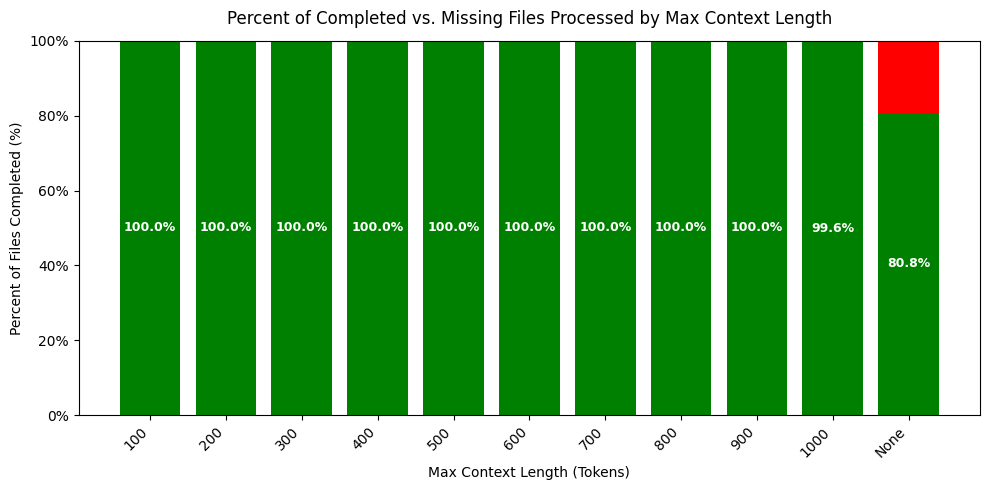

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = actual_df.copy()

# x-axis transform: NaN -> "None"; else int -> str
df["max_context_cat"] = df["max_context_length"].map(
    lambda v: "None" if pd.isna(v) else str(int(v))
)

# ordered categorical: numeric ascending then "None" last (if present)
numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
x_order = [str(v) for v in numeric_levels]
if (df["max_context_cat"] == "None").any():
    x_order.append("None")

df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=x_order, ordered=True)

# If you have multiple rows per max_context_length, aggregate first (mean here)
plot_df = (
    df.groupby("max_context_cat", as_index=False)[["complete_pct", "missing_pct"]]
      .mean()
      .sort_values("max_context_cat")
)

x_labels = plot_df["max_context_cat"].astype(str).to_list()
complete = plot_df["complete_pct"].to_numpy()
missing  = plot_df["missing_pct"].to_numpy()

x = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x, complete, color="green")
ax.bar(x, missing, bottom=complete, color="red")

# label completed % in middle of green segment if > 0
for i, c in enumerate(complete):
    if c > 0:
        ax.text(
            x[i],
            c / 2,
            f"{round(c * 100, 1)}%",
            ha="center",
            va="center",
            color="white",
            fontsize=9,
            fontweight="bold",
        )

ax.set_ylim(0, 1)
ax.set_ylabel("Percent of Files Completed (%)")
ax.set_xlabel("Max Context Length (Tokens)")
ax.set_title("Percent of Completed vs. Missing Files Processed by Max Context Length", pad=12)

ticks = np.linspace(0, 1, 6)
ax.set_yticks(ticks)
ax.set_yticklabels([f"{int(t*100)}%" for t in ticks])

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


<positron-console-cell-240>:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


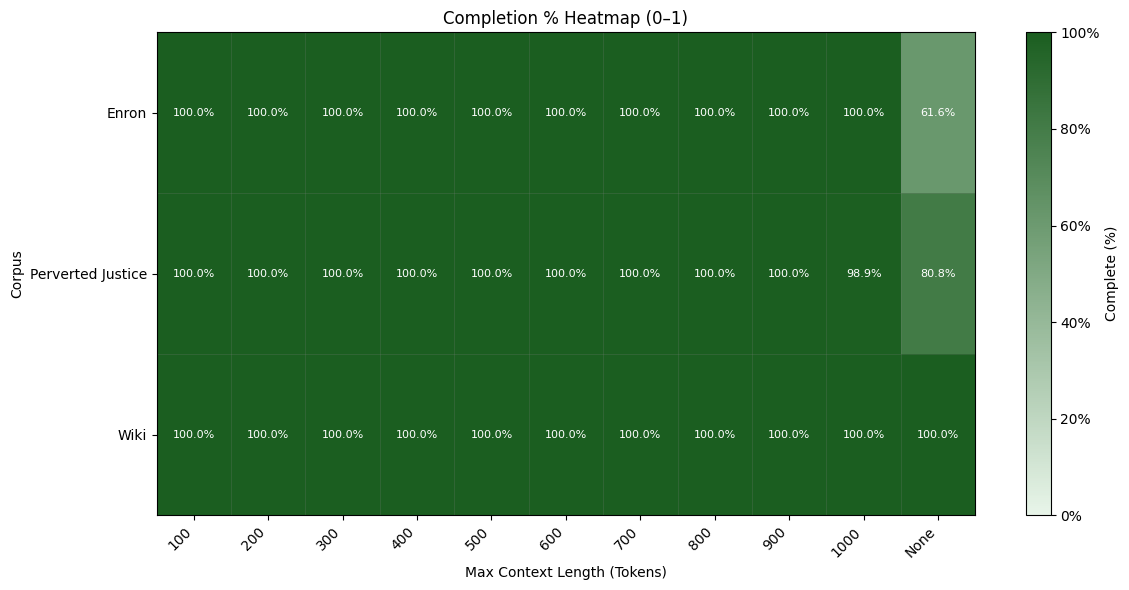

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = actual_df.copy()

# x-axis transform: NaN -> "None"; else int -> str
df["max_context_cat"] = df["max_context_length"].map(
    lambda v: "None" if pd.isna(v) else str(int(v))
)

# ordered categorical: numeric ascending then "None" last (if present)
numeric_levels = sorted({int(v) for v in df.loc[df["max_context_cat"] != "None", "max_context_cat"]})
col_order = [str(v) for v in numeric_levels]
if (df["max_context_cat"] == "None").any():
    col_order.append("None")

df["max_context_cat"] = pd.Categorical(df["max_context_cat"], categories=col_order, ordered=True)

heat = (
    df.pivot_table(
        index="corpus",
        columns="max_context_cat",
        values="complete_pct",
        aggfunc="mean"
    )
    .sort_index()
    .reindex(columns=col_order)
)

data = heat.to_numpy()
masked = np.ma.masked_invalid(data)

# light green -> dark green colormap
greens = LinearSegmentedColormap.from_list(
    "light_to_dark_green",
    ["#e8f5e9", "#1b5e20"]
).copy()
greens.set_bad(color="lightgrey")

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(masked, aspect="auto", vmin=0, vmax=1, cmap=greens)

ax.set_xlabel("Max Context Length (Tokens)")
ax.set_ylabel("Corpus")
ax.set_title("Completion % Heatmap (0–1)")

ax.set_xticks(np.arange(heat.shape[1]))
ax.set_xticklabels([str(c) for c in heat.columns], rotation=45, ha="right")

ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)

# Cell labels: percent, 1dp (skip NaNs)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        v = data[i, j]
        if np.isfinite(v):
            ax.text(
                j, i,
                f"{v*100:.1f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black" if v < 0.55 else "white"
            )

# Faint grey gridlines between cells
ax.set_xticks(np.arange(-0.5, heat.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, heat.shape[0], 1), minor=True)
ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.5, alpha=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

cbar = fig.colorbar(im, ax=ax)

# show 0–100% instead of 0–1
ticks = np.linspace(0, 1, 6)  # 0, 0.2, ..., 1
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t*100:.0f}%" for t in ticks])
cbar.set_label("Complete (%)")

plt.tight_layout()
plt.show()


In [106]:
started_data = actual_df[actual_df['status'] != 'NOT_STARTED']
started_data

,data_type,corpus,model,max_context_length,expected_num_files,actual_num_files,delta,missing,extra,status
0,training,Enron,gpt2,NaN,224,138,-86,86,0,MISSING
1,training,Enron,gpt2,100.0,224,224,0,0,0,COMPLETED
6,training,Enron,gpt2,600.0,224,224,0,0,0,COMPLETED
8,training,Enron,gpt2,800.0,224,224,0,0,0,COMPLETED
10,training,Enron,gpt2,1000.0,224,83,-141,141,0,MISSING


In [51]:
completed_data = actual_df[actual_df['status'] == 'COMPLETED']
completed_data

,data_type,corpus,model,max_context_length,expected_num_files,actual_num_files,delta,missing,extra,status
0,test,Wiki,gpt2,NaN,672,672,0,0,0,COMPLETED
1,test,Wiki,gpt2,100.0,672,672,0,0,0,COMPLETED
2,test,Wiki,gpt2,200.0,672,672,0,0,0,COMPLETED
3,test,Wiki,gpt2,300.0,672,672,0,0,0,COMPLETED
4,test,Wiki,gpt2,400.0,672,672,0,0,0,COMPLETED
5,test,Wiki,gpt2,500.0,672,672,0,0,0,COMPLETED
6,test,Wiki,gpt2,600.0,672,672,0,0,0,COMPLETED
7,test,Wiki,gpt2,700.0,672,672,0,0,0,COMPLETED
8,test,Wiki,gpt2,800.0,672,672,0,0,0,COMPLETED
9,test,Wiki,gpt2,900.0,672,672,0,0,0,COMPLETED


In [52]:
def compare_complete_to_metadata(metadata_base_loc, data_type, corpus, model, excel_files):
    
    metadata_loc = f"{metadata_base_loc}/{data_type}/doc_level_metadata.rds"
    
    metadata = read_rds(metadata_loc)
    metadata = metadata[metadata['corpus'] == corpus]
    metadata['scoring_model'] = model
    
    file_names = [ef.name for ef in excel_files]
    # df with filename + completed=True
    df = pd.DataFrame({
        "filename": file_names,
        "completed": True
    })

    # left join onto metadata_df and fill missing completed with False
    metadata_df = (
        metadata
        .merge(df, on="filename", how="left")
    )

    metadata_df["completed"] = metadata_df["completed"].fillna(False).astype(bool)
    metadata_df["scored"] = False
    
    return metadata_df

In [53]:
def create_problem_complete_metadata(metadata: pd.DataFrame) -> pd.DataFrame:
    """
    Groups by (data_type, corpus, scoring_model, problem) and returns:
      - num_files: total rows
      - files_completed: count where completed == True
      - files_scored: count where scored == True
      - problem_completed: True if num_files == files_scored
    """
    group_cols = ["data_type", "corpus", "scoring_model", "problem"]

    out = (
        metadata
        .groupby(group_cols, dropna=False)
        .agg(
            num_files=("filename", "size"),
            files_completed=("completed", lambda s: int(s.fillna(False).astype(bool).sum())),
            files_scored=("scored", lambda s: int(s.fillna(False).astype(bool).sum())),
        )
        .reset_index()
    )

    out["problem_completed"] = out["num_files"] == out["files_scored"]
    return out

In [98]:
def build_and_save_token_level_raw_scores(
    completed_df: pd.DataFrame,
    base_loc: str | Path,
    metadata_base_loc: str | Path,
    *,
    sheet_name: str = "metadata",
    output_name: str = "token_level_raw_scores.xlsx",
    recursive: bool = False,
    engine: str | None = None,
    overwrite: bool = False
) -> None:
    """
    For each row in completed_df, read all .xlsx files in:
        {base_loc}/{data_type}/{corpus}/{model}/raw
    Extract `sheet_name`, concat, sort by sample_id then min_token_size,
    and save to:
        {base_loc}/{data_type}/{corpus}/{model}/{output_name}

    Skips if output file already exists.
    """
    base_loc = Path(base_loc)

    required_cols = {"data_type", "corpus", "model"}
    missing = required_cols - set(completed_df.columns)
    if missing:
        raise ValueError(f"completed_df is missing required columns: {sorted(missing)}")

    for row in completed_df.itertuples(index=False):
        data_type = getattr(row, "data_type")
        corpus = getattr(row, "corpus")
        model = getattr(row, "model")

        raw_dir = base_loc / data_type / corpus / model / "raw"
        out_path = raw_dir.parent / output_name  # removes /raw
        metadata_out_path = base_loc / data_type / corpus / model / "raw_problem_metadata.xlsx"
        summary_metadata_out_path = base_loc / data_type / corpus / model / "raw_problem_completed_metadata.xlsx"
        
        # skip if output already exists
        if not overwrite:
            if out_path.exists():
                print(f"SKIP (exists): {out_path}")
                continue

        # if raw dir missing / empty, skip
        if not raw_dir.exists():
            print(f"SKIP (no dir): {raw_dir}")
            continue

        excel_files = list_xlsx_files(raw_dir, recursive=recursive)
        if not excel_files:
            print(f"SKIP (no files): {raw_dir}")
            continue

        base_metadata = compare_complete_to_metadata(metadata_base_loc, data_type, corpus, model, excel_files)
        
        combined_metadata = []

        for ef in excel_files:
            f_name = ef.name
            try:
                data = read_excel_sheets(ef, [sheet_name])
                combined_metadata.append(data[sheet_name])
                
                # ✅ mark as scored if read succeeded
                base_metadata.loc[base_metadata["filename"] == f_name, "scored"] = True
            except Exception as e:
                print(f"  WARN: failed reading {sheet_name} from {ef}: {e}")

        if not combined_metadata:
            print(f"SKIP (no readable sheets): {raw_dir}")
            continue

        results = (
            pd.concat(combined_metadata, ignore_index=True)
            .sort_values(["sample_id", "min_token_size"], ascending=[True, True], kind="mergesort")
            .reset_index(drop=True)
        )

        # insert data_type before corpus, scoring_model after corpus
        if "corpus" in results.columns:
            corpus_idx = results.columns.get_loc("corpus")

            if "data_type" in results.columns:
                results.drop(columns=["data_type"], inplace=True)
            results.insert(corpus_idx, "data_type", data_type)

            corpus_idx = results.columns.get_loc("corpus")  # re-fetch
            if "scoring_model" in results.columns:
                results.drop(columns=["scoring_model"], inplace=True)
            results.insert(corpus_idx + 1, "scoring_model", model)
            
        # move problem before known_author (always move; adjust index if problem was before)
        if "problem" in results.columns and "known_author" in results.columns:
            problem_idx = results.columns.get_loc("problem")
            known_author_idx = results.columns.get_loc("known_author")

            problem_col = results.pop("problem")

            # if problem was before known_author, known_author shifted left by 1 after pop
            if problem_idx < known_author_idx:
                known_author_idx -= 1

            results.insert(known_author_idx, "problem", problem_col)
        
        # ensure parent exists, then save
        out_path.parent.mkdir(parents=True, exist_ok=True)
        results.to_excel(out_path, index=False)
        print(f"SAVED: {out_path}  (rows={len(results)})")
        
        # Also want to save the metadata
        base_metadata.to_excel(metadata_out_path, index=False)
        
        summary_metadata = create_problem_complete_metadata(base_metadata)
        summary_metadata.to_excel(summary_metadata_out_path, index=False)

In [57]:
def build_and_save_token_level_raw_scores(
    completed_df: pd.DataFrame,
    base_loc: str | Path,
    metadata_base_loc: str | Path,
    *,
    raw_subdirs: Sequence[str] = ("raw",),
    save_dirname: str | None = None,   # NEW: e.g. "compiled" or "aggregates"
    sheet_name: str = "metadata",
    output_name: str = "token_level_raw_scores.xlsx",
    recursive: bool = False,
    engine: str | None = None,
    overwrite: bool = False,
) -> None:
    """
    For each row in completed_df, read all .xlsx files in:
        {base_loc}/{data_type}/{corpus}/{model}/{raw_subdir}

    Save outputs either:
      - alongside raw_subdir parent (default, original behaviour), OR
      - under {base_loc}/{data_type}/{corpus}/{model}/{save_dirname}/ (if provided)

    If multiple raw_subdirs are provided and output_name does NOT include "{raw_subdir}",
    output files are auto-suffixed to avoid collisions.
    """
    base_loc = Path(base_loc)
    metadata_base_loc = Path(metadata_base_loc)

    def _render_name(name: str, raw_subdir: str, *, disambiguate: bool) -> str:
        if "{raw_subdir}" in name:
            return name.format(raw_subdir=raw_subdir)
        if disambiguate:
            p = Path(name)
            return f"{p.stem}_{raw_subdir}{p.suffix}"
        return name

    if isinstance(raw_subdirs, str):
        raw_subdirs = (raw_subdirs,)

    disambiguate_names = len(tuple(raw_subdirs)) > 1

    required_cols = {"data_type", "corpus", "model"}
    missing = required_cols - set(completed_df.columns)
    if missing:
        raise ValueError(f"completed_df is missing required columns: {sorted(missing)}")

    for row in completed_df.itertuples(index=False):
        data_type = getattr(row, "data_type")
        corpus = getattr(row, "corpus")
        model = getattr(row, "model")

        model_dir = base_loc / data_type / corpus / model
        save_base = (model_dir / save_dirname) if save_dirname else model_dir

        for raw_subdir in raw_subdirs:
            raw_dir = model_dir / raw_subdir

            out_name = _render_name(output_name, raw_subdir, disambiguate=disambiguate_names)
            meta_name = _render_name("raw_problem_metadata.xlsx", raw_subdir, disambiguate=disambiguate_names)
            summary_meta_name = _render_name(
                "raw_problem_completed_metadata.xlsx", raw_subdir, disambiguate=disambiguate_names
            )

            out_path = save_base / out_name
            metadata_out_path = save_base / meta_name
            summary_metadata_out_path = save_base / summary_meta_name

            # skip if output already exists
            if not overwrite and out_path.exists():
                print(f"SKIP (exists): {out_path}")
                continue

            # if raw dir missing / empty, skip
            if not raw_dir.exists():
                print(f"SKIP (no dir): {raw_dir}")
                continue

            excel_files = list_xlsx_files(raw_dir, recursive=recursive)
            if not excel_files:
                print(f"SKIP (no files): {raw_dir}")
                continue

            base_metadata = compare_complete_to_metadata(
                metadata_base_loc, data_type, corpus, model, excel_files
            )

            combined_metadata: list[pd.DataFrame] = []

            for ef in excel_files:
                f_name = ef.name
                try:
                    data = read_excel_sheets(ef, [sheet_name])
                    combined_metadata.append(data[sheet_name])

                    # ✅ mark as scored if read succeeded
                    base_metadata.loc[base_metadata["filename"] == f_name, "scored"] = True
                except Exception as e:
                    print(f"  WARN: failed reading {sheet_name} from {ef}: {e}")

            if not combined_metadata:
                print(f"SKIP (no readable sheets): {raw_dir}")
                continue

            results = (
                pd.concat(combined_metadata, ignore_index=True)
                .sort_values(["sample_id", "min_token_size"], ascending=[True, True], kind="mergesort")
                .reset_index(drop=True)
            )

            # insert data_type before corpus, scoring_model after corpus
            if "corpus" in results.columns:
                corpus_idx = results.columns.get_loc("corpus")

                if "data_type" in results.columns:
                    results.drop(columns=["data_type"], inplace=True)
                results.insert(corpus_idx, "data_type", data_type)

                corpus_idx = results.columns.get_loc("corpus")  # re-fetch
                if "scoring_model" in results.columns:
                    results.drop(columns=["scoring_model"], inplace=True)
                results.insert(corpus_idx + 1, "scoring_model", model)

            # move problem before known_author
            if "problem" in results.columns and "known_author" in results.columns:
                problem_idx = results.columns.get_loc("problem")
                known_author_idx = results.columns.get_loc("known_author")

                problem_col = results.pop("problem")
                if problem_idx < known_author_idx:
                    known_author_idx -= 1

                results.insert(known_author_idx, "problem", problem_col)

            # ensure save dir exists, then save
            save_base.mkdir(parents=True, exist_ok=True)

            results.to_excel(out_path, index=False, engine=engine)
            print(f"SAVED: {out_path}  (rows={len(results)})")

            base_metadata.to_excel(metadata_out_path, index=False, engine=engine)

            summary_metadata = create_problem_complete_metadata(base_metadata)
            summary_metadata.to_excel(summary_metadata_out_path, index=False, engine=engine)


In [58]:
build_and_save_token_level_raw_scores(
    completed_data,
    base_loc=base_loc,
    metadata_base_loc=metadata_base_loc,
    raw_subdirs=("raw"),
    save_dirname="raw_results",
)

<positron-console-cell-58>:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


SAVED: /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx  (rows=1973)
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/raw_results/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_mas

In [55]:
build_and_save_token_level_raw_scores(
    completed_data,
    base_loc=base_loc,
    metadata_base_loc=metadata_base_loc,
    raw_subdirs=("raw", "raw_100", "raw_200"),
    output_name="token_level_raw_scores_by_context.xlsx"
)


<positron-console-cell-55>:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


SAVED: /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw.xlsx  (rows=1973)


<positron-console-cell-55>:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


SAVED: /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_100.xlsx  (rows=1973)


<positron-console-cell-55>:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


SAVED: /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_200.xlsx  (rows=1973)
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_100.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_200.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_100.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/gpt2/token_level_raw_scores_by_context_raw_200.xlsx
SKIP (exists): /Volumes

In [99]:
build_and_save_token_level_raw_scores(
    completed_data,
    base_loc,
    metadata_base_loc,
    sheet_name = "metadata",
    output_name = "token_level_raw_scores.xlsx",
    overwrite=False
)

SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Enron/Qwen2.5-0.5B-Instruct/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Enron/Qwen2.5-1.5B-Instruct/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Enron/gemma-3-270m/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Perverted Justice/Qwen2.5-0.5B-Instruct/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Perverted Justice/Qwen2.5-1.5B-Instruct/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Perverted Justice/gemma-3-270m/token_level_raw_scores.xlsx
SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Wiki/Qwen2.5-0.5B-Instruct/token_level_raw_scores.xlsx
SKIP (exis

In [100]:
manual_df = actual_df[
    (actual_df['data_type'] == 'test')
    & (actual_df['corpus'] == 'Perverted Justice')
    & (actual_df['model'] == 'gpt2')
]

manual_df

,data_type,corpus,model,expected_num_files,actual_num_files,delta,missing,extra,status
11,test,Perverted Justice,gpt2,574,491,-83,83,0,MISSING


In [101]:
build_and_save_token_level_raw_scores(
    manual_df,
    base_loc,
    metadata_base_loc,
    sheet_name = "metadata",
    output_name = "token_level_raw_scores.xlsx"
)

SKIP (exists): /Volumes/BCross/av_datasets_experiments/ngram_masking_logrpobs/test/Perverted Justice/gpt2/token_level_raw_scores.xlsx
